In [34]:
from google.colab import drive
from google.colab import files
import sys

drive.mount('/content/gdrive/', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'Colab Notebooks/MS Thesis/Preconditioned SGD/MNIST'
sys.path.append(base_dir)

Mounted at /content/gdrive/


In [0]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import time
import math
import preconditioned_stochastic_gradient_descent as psgd 
from tabulate import tabulate
import scipy.io

## Download MNIST Data

In [36]:
"""MNIST, classification"""
np.random.seed(0)

# Parameter Settings
batch_size = 128
num_f = 32  # number of features 

dtype = tf.float32

mnist = tf.contrib.learn.datasets.load_dataset('mnist')

Extracting MNIST-data/train-images-idx3-ubyte.gz
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz


In [37]:
train_data = np.concatenate((mnist.train.images, mnist.validation.images), axis = 0)

print('total images:',train_data.shape[0])
print('training images:',mnist.train.images.shape[0])
print('validation images:',mnist.validation.images.shape[0])
print('number of features:',mnist.validation.images.shape[1])

# reshape data as 28x28x1 image 
train_data = np.reshape(2.0*train_data - 1.0, [60000, 28, 28, 1])

#binarize the labels
train_label = np.zeros([60000, 10])
train_label[np.arange(60000), np.concatenate((mnist.train.labels, mnist.validation.labels), axis = 0)] = 1.0

test_label = np.zeros([10000, 10])
test_label[np.arange(10000), mnist.test.labels] = 1.0


total images: 60000
training images: 55000
validation images: 5000
number of features: 784


In [0]:
def get_batches():
    # generate 60000 numbers randomly without replacement
    rp = np.random.permutation(train_data.shape[0])
    x = -np.ones([batch_size, 32, 32, 1])
    
    # augumentation: randomly shifting image by +-2 pixels 
    for i in range(batch_size):
        m = math.floor(5.0*np.random.rand())
        n = math.floor(5.0*np.random.rand())
        x[i, m:m+28, n:n+28] = train_data[rp[i]]
    y = train_label[rp[0:batch_size]]
    return x, y

## Defining CNN model for training.
The model consists of 2 convolutional layers, 1 avgpool layer, 2 convolutional layers, 1 avg pool layer, 1 FC layer, 1 FC layer.

In [0]:
train_inputs = tf.placeholder(dtype, [batch_size, 32, 32, 1])
train_outputs = tf.placeholder(dtype, [batch_size, 10])
adam_step = tf.placeholder(tf.float32, shape = ())

In [0]:
# (hight, width, in_ch, out_ch) tensor --> (hight * width * in_ch, out_ch) matrix 
W1 = tf.Variable(np.random.normal(loc=0.0, scale=1.0/np.sqrt(3*3*1+1), size=[3*3*1+1, num_f]), dtype=dtype)
W2 = tf.Variable(np.random.normal(loc=0.0, scale=1.0/np.sqrt(3*3*num_f+1), size=[3*3*num_f+1, num_f]), dtype=dtype)
W3 = tf.Variable(np.random.normal(loc=0.0, scale=1.0/np.sqrt(3*3*num_f+1), size=[3*3*num_f+1, num_f]), dtype=dtype)
W4 = tf.Variable(np.random.normal(loc=0.0, scale=1.0/np.sqrt(3*3*num_f+1), size=[3*3*num_f+1, num_f]), dtype=dtype)
W5 = tf.Variable(np.random.normal(loc=0.0, scale=1.0/np.sqrt(5*5*num_f+1), size=[5*5*num_f+1, 10]), dtype=dtype)
Ws = [W1, W2, W3, W4, W5]

# we use the traditional tanh
def model(Ws, inputs):
    
    # W1, W2, W3, W4, W5 = Ws
    # w1 = tf.reshape(W1[:-1], [3, 3, 1, num_f])
    # b1 = W1[-1]
    # x1 = tf.tanh( tf.nn.conv2d(input = inputs,filters = w1, strides = [1,1,1,1], padding = 'VALID') + b1 )
    
        
    # w2 = tf.reshape(W2[:-1], [3, 3, num_f, num_f])
    # b2 = W2[-1]
    # x2 = tf.tanh( tf.nn.conv2d(input = x1, filters = w2, strides = [1,1,1,1], padding = 'VALID') + b2 )
    
    # x2 = tf.nn.avg_pool(value = x2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
        
    # w3 = tf.reshape(W3[:-1], [3, 3, num_f, num_f])
    # b3 = W3[-1]
    # x3 = tf.tanh( tf.nn.conv2d(x2, w3, [1,1,1,1], 'VALID') + b3 )
        
    # w4 = tf.reshape(W4[:-1], [3, 3, num_f, num_f])
    # b4 = W4[-1]
    # x4 = tf.tanh( tf.nn.conv2d(x3, w4, [1,1,1,1], 'VALID') + b4 )
    
    # x4 = tf.nn.avg_pool(value = x4, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'VALID')
    
    # batch_size = inputs.shape.as_list()[0]
    # x4_flat = tf.reshape(x4, [batch_size, -1])
    # ones = tf.ones([batch_size, 1], dtype=dtype)
    # y = tf.matmul(tf.concat([x4_flat, ones], axis = 1), W5)
    W1, W2, W3, W4, W5 = Ws
    w1 = tf.reshape(W1[:-1], [3, 3, 1, num_f])
    b1 = W1[-1]
    x1 = tf.nn.relu( tf.nn.conv2d(input = inputs,filters = w1, strides = [1,1,1,1], padding = 'VALID') + b1 )
    
        
    w2 = tf.reshape(W2[:-1], [3, 3, num_f, num_f])
    b2 = W2[-1]
    x2 = tf.nn.relu( tf.nn.conv2d(input = x1, filters = w2, strides = [1,1,1,1], padding = 'VALID') + b2 )
    
    x2 = tf.nn.avg_pool(value = x2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
        
    w3 = tf.reshape(W3[:-1], [3, 3, num_f, num_f])
    b3 = W3[-1]
    x3 = tf.nn.relu( tf.nn.conv2d(x2, w3, [1,1,1,1], 'VALID') + b3 )
        
    w4 = tf.reshape(W4[:-1], [3, 3, num_f, num_f])
    b4 = W4[-1]
    x4 = tf.nn.relu( tf.nn.conv2d(x3, w4, [1,1,1,1], 'VALID') + b4 )
    
    x4 = tf.nn.avg_pool(value = x4, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'VALID')
    
    batch_size = inputs.shape.as_list()[0]
    x4_flat = tf.reshape(x4, [batch_size, -1])
    ones = tf.ones([batch_size, 1], dtype=dtype)
    y = tf.matmul(tf.concat([x4_flat, ones], axis = 1), W5)
    return y


## Define cross entropy as Training Loss function (Loss function) and Test Loss function

In [0]:
# cross entropy loss
def train_criterion(Ws):
    y = model(Ws, train_inputs)
    return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=train_outputs, logits=y))


test_data = -np.ones([10000, 32, 32, 1])
test_data[:,2:30,2:30] = np.reshape(2.0*mnist.test.images - 1.0, [10000, 28, 28, 1])

test_outputs = mnist.test.labels
# classification error rate
def test_criterion(Ws):
    y = model(Ws, tf.constant(test_data, dtype=dtype))
    # return 1 - accuracy 
    return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=test_label, logits=y))
    # return 1.0 - tf.reduce_mean(tf.cast(tf.equal(tf.argmax(y, axis=1), tf.constant(mnist.test.labels, dtype=tf.int64)), dtype=dtype))

# SGD

train loss: 2.3416266441345215; test loss: 2.3795721530914307; time:0.2564117908477783
train loss: 2.129493093740942; test loss: 1.712567925453186; time:0.804816722869873
train loss: 1.7301640037043682; test loss: 0.9955306649208069; time:1.339977741241455
train loss: 1.3869067422479129; test loss: 0.7374476790428162; time:1.8807694911956787
train loss: 1.1529156055903163; test loss: 0.6528586745262146; time:2.42340087890625
train loss: 1.0331668954008892; test loss: 0.5775043368339539; time:2.9509785175323486
train loss: 0.9650555504074526; test loss: 0.537527322769165; time:3.4914212226867676
train loss: 0.9196018995846925; test loss: 0.5248585939407349; time:4.029218673706055
train loss: 0.8852696506542191; test loss: 0.4937375485897064; time:4.56253981590271
train loss: 0.8603933846082151; test loss: 0.470369815826416; time:5.103893280029297
train loss: 0.8443699905698616; test loss: 0.45536309480667114; time:5.635470867156982
train loss: 0.8281574479687346; test loss: 0.4311011731

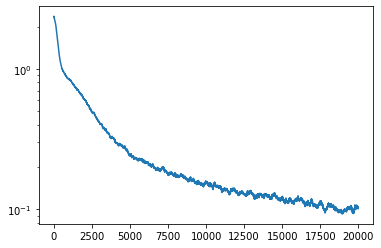

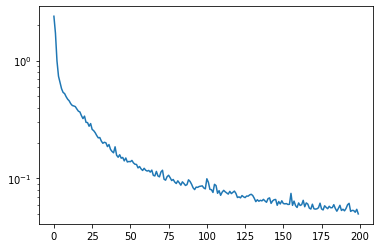

In [42]:
step_size = 0.01
grad_norm_clip_thr = 1e0 # may need gradients cliping for RNN training; otherwise, set it to an extremely large value  

with tf.Session() as sess:
    
    train_loss = train_criterion(Ws)
    grads = tf.gradients(train_loss, Ws)
    grad_norm = tf.sqrt(tf.reduce_sum([tf.reduce_sum(g*g) for g in grads]))
    step_size_adjust = tf.minimum(1.0, grad_norm_clip_thr/(grad_norm + 1.2e-38))
    new_Ws = [W - (step_size_adjust*step_size)*g for (W, g) in zip(Ws, grads)]
    update_Ws = [tf.assign(W, new_W) for (W, new_W) in zip(Ws, new_Ws)]
    
    test_loss = test_criterion(Ws)

    sess.run(tf.global_variables_initializer())
    avg_train_loss = 0.0
    TrainLoss = list()
    TestLoss = list()
    Time = list()
    for num_iter in range(20000):    
        _train_inputs, _train_outputs = get_batches( )
     
        t0 = time.time()
        _train_loss, _ = sess.run([train_loss, update_Ws],
                                  {train_inputs: _train_inputs, train_outputs: _train_outputs})     
        Time.append(time.time() - t0)
        
        nu = min(num_iter/(1.0 + num_iter), 0.99)
        avg_train_loss = nu*avg_train_loss + (1.0 - nu)*_train_loss
        TrainLoss.append(avg_train_loss)
        if num_iter % 100 == 0:
            _test_loss = sess.run(test_loss)
            TestLoss.append(_test_loss)
            print('train loss: {}; test loss: {}; time:{}'.format(TrainLoss[-1],TestLoss[-1], np.sum(Time)))


plt.figure(1)
plt.semilogy(TrainLoss)
plt.figure(2)
plt.semilogy(TestLoss)

 
scipy.io.savemat('/content/gdrive/My Drive/Colab Notebooks/MS Thesis/Preconditioned SGD/MNIST/results/SGD.mat', {'TrainLoss': TrainLoss, 'TestLoss': TestLoss,'Time':Time})

# ADAM

train loss: 2.4485554695129395; test loss: 2.6588125228881836; Time: 0.28653693199157715
train loss: 0.7816918224103753; test loss: 0.11692517250776291; Time: 0.9096105098724365
train loss: 0.38684126924982454; test loss: 0.07206304371356964; Time: 1.5253674983978271
train loss: 0.21333126167439984; test loss: 0.07397979497909546; Time: 2.138470411300659
train loss: 0.1464031946387965; test loss: 0.04752451181411743; Time: 2.746488094329834
train loss: 0.10407002568406011; test loss: 0.048835039138793945; Time: 3.3653528690338135
train loss: 0.08798124890175703; test loss: 0.045007359236478806; Time: 3.975539445877075
train loss: 0.08005764910284849; test loss: 0.03795579448342323; Time: 4.583475112915039
train loss: 0.0763897888984328; test loss: 0.041369032114744186; Time: 5.208379745483398
train loss: 0.07070292911426423; test loss: 0.03537023812532425; Time: 5.815263986587524
train loss: 0.06573601543456582; test loss: 0.03487734869122505; Time: 6.422024488449097
train loss: 0.0587

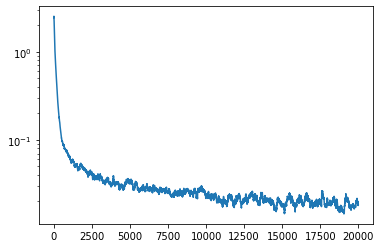

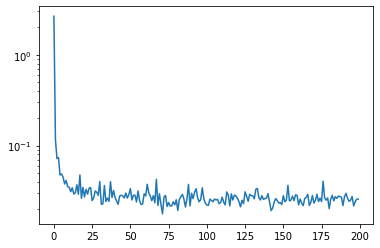

In [43]:
# Adam 
step_size = 0.005
beta1 = 0.9
beta2 = 0.999
offset = 1e-9
         
with tf.Session() as sess:
    grads_vars = [tf.Variable(tf.zeros(W.shape, dtype=dtype), trainable=False) for W in Ws]
    grads_moment = [tf.Variable(tf.zeros(W.shape, dtype=dtype), trainable=False) for W in Ws]
    
    train_loss = train_criterion(Ws)
    grads = tf.gradients(train_loss, Ws)
    new_grads_moment = [beta1*m + (1.0 - beta1)*g for (m, g) in zip(grads_moment, grads)]
    new_grads_vars = [beta2*v + (1.0 - beta2)*g*g for (v, g) in zip(grads_vars, grads)]
    new_grads_moment_hat = [m/(1-beta1**adam_step) for m in new_grads_moment]
    new_grads_vars_hat = [v/(1-beta2**adam_step) for v in new_grads_vars]
          
    new_Ws = [W - step_size*m/(tf.sqrt(v) + offset) for (W, m, v) in zip(Ws, new_grads_moment_hat, new_grads_vars_hat)]
  
    update_Ws = [tf.assign(old, new) for (old, new) in zip(Ws, new_Ws)]
    update_grads_vars = [tf.assign(old, new) for (old, new) in zip(grads_vars, new_grads_vars)]
    update_grads_moment = [tf.assign(old, new) for (old, new) in zip(grads_moment, new_grads_moment)]
    
    test_loss = test_criterion(Ws)
    
    sess.run(tf.global_variables_initializer())
    avg_train_loss = 0.0
    TrainLoss = list()
    TestLoss = list()
    Time = list()
    t = 0
    for num_iter in range(20000):    
        _train_inputs, _train_outputs = get_batches()
     
        t = t + 1
        t0 = time.time()
        _train_loss, _,_,_ = sess.run([train_loss, update_Ws, update_grads_vars, update_grads_moment],
                                      {train_inputs: _train_inputs, train_outputs: _train_outputs, adam_step:t})  
        
        Time.append(time.time() - t0)
        nu = min(num_iter/(1.0 + num_iter), 0.99)
        avg_train_loss = nu*avg_train_loss + (1.0 - nu)*_train_loss
        TrainLoss.append(avg_train_loss)
        if num_iter % 100 == 0:
            _test_loss = sess.run(test_loss)
            TestLoss.append(_test_loss)
            print('train loss: {}; test loss: {}; Time: {}'.format(TrainLoss[-1], TestLoss[-1],np.sum(Time)))


plt.figure(1)
plt.semilogy(TrainLoss)
plt.figure(2)
plt.semilogy(TestLoss)

scipy.io.savemat('/content/gdrive/My Drive/Colab Notebooks/MS Thesis/Preconditioned SGD/MNIST/results/adam.mat', {'TrainLoss': TrainLoss, 'TestLoss': TestLoss,'Time':Time})

# ESGD

train loss: 2.4157216548919678; test loss: 2.3948733806610107; Time: 0.577153205871582
train loss: 1.9653499884009358; test loss: 1.23285973072052; Time: 1.7748172283172607
train loss: 1.4119583374111844; test loss: 0.5957586765289307; Time: 2.978020191192627
train loss: 1.0147277586961931; test loss: 0.4146098494529724; Time: 4.171355724334717
train loss: 0.7598158638073306; test loss: 0.29822486639022827; Time: 5.358316659927368
train loss: 0.5641062402684913; test loss: 0.2266232967376709; Time: 6.556103706359863
train loss: 0.4658572696510497; test loss: 0.19581274688243866; Time: 7.7514753341674805
train loss: 0.3879609112738275; test loss: 0.16658428311347961; Time: 8.950193405151367
train loss: 0.3311269364390977; test loss: 0.15006357431411743; Time: 10.145894527435303
train loss: 0.29727332217322877; test loss: 0.12945930659770966; Time: 11.343055725097656
train loss: 0.26762652010167104; test loss: 0.12270961701869965; Time: 12.53964614868164
train loss: 0.2405885774048237; t

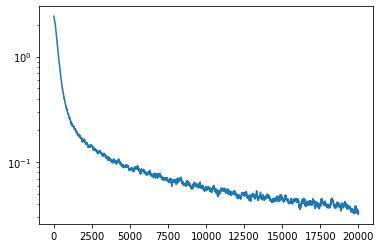

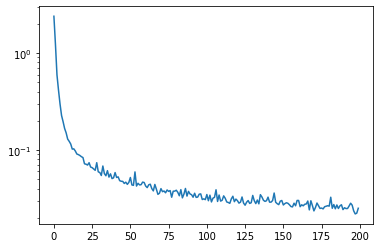

In [44]:
step_size = 0.02
grad_norm_clip_thr = 1e0
max_mu = 0.99 
offset = 1e-9 
         
with tf.Session() as sess:
    dws2 = [tf.Variable(tf.zeros(W.shape, dtype=dtype), trainable=False) for W in Ws] # delta_W**2
    dgs2 = [tf.Variable(tf.zeros(W.shape, dtype=dtype), trainable=False) for W in Ws] # delta_grad**2
    mu = tf.Variable(initial_value=0.0, trainable=False, dtype=dtype) # forgetting factor for dws2, dgs2 estimation
        
    train_loss = train_criterion(Ws)
    grads = tf.gradients(train_loss, Ws)
    
    delta_Ws = [tf.random_normal(W.shape, dtype=dtype) for W in Ws]
    grad_deltaw = tf.reduce_sum([tf.reduce_sum(g*v) for (g, v) in zip(grads, delta_Ws)]) # grads * delta_Ws
    hess_deltaw = tf.gradients(grad_deltaw, Ws) # Hessian * delta_Ws

    new_dws2 = [mu*old + (1.0 - mu)*new*new for (old, new) in zip(dws2, delta_Ws)]    
    new_dgs2 = [mu*old + (1.0 - mu)*new*new for (old, new) in zip(dgs2, hess_deltaw)]
    
    precond_grads = [g*tf.sqrt(dw/(dg + offset)) for (g, dw, dg) in zip(grads, new_dws2, new_dgs2)]
    grad_norm = tf.sqrt(tf.reduce_sum([tf.reduce_sum(g*g) for g in precond_grads]))
    step_size_adjust = tf.minimum(1.0, grad_norm_clip_thr/(grad_norm + 1.2e-38))
    new_Ws = [W - (step_size_adjust*step_size)*g for (W, g) in zip(Ws, precond_grads)]
    new_mu = tf.minimum(max_mu, 1.0/(2.0 - mu))
    
    update_Ws = [tf.assign(old, new) for (old, new) in zip(Ws, new_Ws)]
    update_dws2 = [tf.assign(old, new) for (old, new) in zip(dws2, new_dws2)]
    update_dgs2 = [tf.assign(old, new) for (old, new) in zip(dgs2, new_dgs2)]
    update_mu = tf.assign(mu, new_mu)
    
    test_loss = test_criterion(Ws)  
       
    sess.run(tf.global_variables_initializer())
    avg_train_loss = 0.0
    TrainLoss = list()
    TestLoss = list()
    Time = list()
    for num_iter in range(20000):    
        _train_inputs, _train_outputs = get_batches( )
    
        t0 = time.time()
        _train_loss, _,_,_,_ = sess.run([train_loss, update_Ws, update_dws2, update_dgs2, update_mu],
                                        {train_inputs: _train_inputs, train_outputs: _train_outputs})
        Time.append(time.time() - t0)
        nu = min(num_iter/(1.0 + num_iter), 0.99)
        avg_train_loss = nu*avg_train_loss + (1.0 - nu)*_train_loss
        TrainLoss.append(avg_train_loss)      
        if num_iter % 100 == 0:
            _test_loss = sess.run(test_loss)
            TestLoss.append(_test_loss)
            print('train loss: {}; test loss: {}; Time: {}'.format(TrainLoss[-1], TestLoss[-1], np.sum(Time)))
    
    
plt.figure(1)
plt.semilogy(TrainLoss)
plt.figure(2)
plt.semilogy(TestLoss)

  
scipy.io.savemat('/content/gdrive/My Drive/Colab Notebooks/MS Thesis/Preconditioned SGD/MNIST/results/ESGD.mat', {'TrainLoss': TrainLoss, 'TestLoss': TestLoss,'Time':Time})

# SGD with RMSprop

train loss: 2.427391529083252; test loss: 2.333625555038452; Time: 0.4722609519958496
train loss: 1.1964147178113467; test loss: 0.3722701966762543; Time: 1.0684378147125244
train loss: 0.6994340960918299; test loss: 0.16442477703094482; Time: 1.6576869487762451
train loss: 0.4332897249477984; test loss: 0.11397189646959305; Time: 2.240978240966797
train loss: 0.2976355257617342; test loss: 0.10028726607561111; Time: 2.8326542377471924
train loss: 0.22683555971589378; test loss: 0.10195792466402054; Time: 3.4172916412353516
train loss: 0.19234570793675354; test loss: 0.14291392266750336; Time: 4.000378131866455
train loss: 0.16196209635600814; test loss: 0.06999252736568451; Time: 4.582211017608643
train loss: 0.13803940399413833; test loss: 0.06764063984155655; Time: 5.1618263721466064
train loss: 0.13273075524421168; test loss: 0.05113290250301361; Time: 5.729511976242065
train loss: 0.12031253699890634; test loss: 0.0473891943693161; Time: 6.2950403690338135
train loss: 0.1115564381

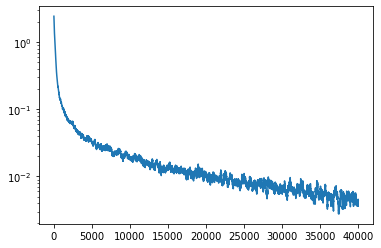

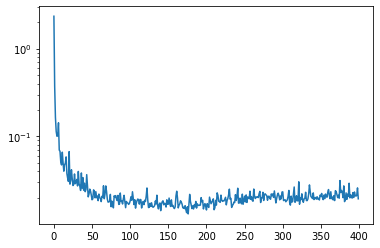

In [61]:
# RMSProp  
step_size = 0.0005
max_mu = 0.99
offset = 1e-9
         
with tf.Session() as sess:
    grads_vars = [tf.Variable(tf.zeros(W.shape, dtype=dtype), trainable=False) for W in Ws]
    mu = tf.Variable(initial_value=0.0, trainable=False, dtype=dtype) # forgetting factor for grads**2 estimation 
    
    train_loss = train_criterion(Ws)
    grads = tf.gradients(train_loss, Ws)
    new_grads_vars = [mu*old + (1.0 - mu)*new*new for (old, new) in zip(grads_vars, grads)]
    new_Ws = [W - step_size*g/tf.sqrt(v + offset) for (W, g, v) in zip(Ws, grads, new_grads_vars)]
    new_mu = tf.minimum(max_mu, 1.0/(2.0 - mu))
    
    update_Ws = [tf.assign(old, new) for (old, new) in zip(Ws, new_Ws)]
    update_grads_vars = [tf.assign(old, new) for (old, new) in zip(grads_vars, new_grads_vars)]
    update_mu = tf.assign(mu, new_mu)
    
    test_loss = test_criterion(Ws)
    
    sess.run(tf.global_variables_initializer())
    avg_train_loss = 0.0
    TrainLoss = list()
    TestLoss = list()
    Time = list()
    for num_iter in range(40000):    
        _train_inputs, _train_outputs = get_batches( )
     
        t0 = time.time()
        _train_loss, _,_,_ = sess.run([train_loss, update_Ws, update_grads_vars, update_mu],
                                      {train_inputs: _train_inputs, train_outputs: _train_outputs})  
        Time.append(time.time() - t0)
        
        nu = min(num_iter/(1.0 + num_iter), 0.99)
        avg_train_loss = nu*avg_train_loss + (1.0 - nu)*_train_loss
        TrainLoss.append(avg_train_loss)
        if num_iter % 100 == 0:
            _test_loss = sess.run(test_loss)
            TestLoss.append(_test_loss)
            print('train loss: {}; test loss: {}; Time: {}'.format(TrainLoss[-1], TestLoss[-1],np.sum(Time)))


plt.figure(1)
plt.semilogy(TrainLoss)
plt.figure(2)
plt.semilogy(TestLoss)

  
scipy.io.savemat('/content/gdrive/My Drive/Colab Notebooks/MS Thesis/Preconditioned SGD/MNIST/results/rmsprop.mat', {'TrainLoss': TrainLoss, 'TestLoss': TestLoss,'Time':Time})

# PSGD with Kronecker Product Preconditioning

train loss: 2.378093957901001; test loss: 2.3364925384521484; Time: 0.7002003192901611
train loss: 1.13178934264779; test loss: 0.2912410497665405; Time: 2.228010654449463
train loss: 0.6425872088629812; test loss: 0.1424219161272049; Time: 3.756328821182251
train loss: 0.37118368310900224; test loss: 0.09737103432416916; Time: 5.261392593383789
train loss: 0.2397889740846927; test loss: 0.07240365445613861; Time: 6.785789489746094
train loss: 0.1712108737762272; test loss: 0.05729157105088234; Time: 8.297892570495605
train loss: 0.1317463510494259; test loss: 0.04859795421361923; Time: 9.83466386795044
train loss: 0.11180181872550277; test loss: 0.043725285679101944; Time: 11.359869241714478
train loss: 0.09310245783927826; test loss: 0.039486609399318695; Time: 12.867769718170166
train loss: 0.08734842570258489; test loss: 0.03973960131406784; Time: 14.373743772506714
train loss: 0.08467274640350629; test loss: 0.03522340580821037; Time: 15.905123710632324
train loss: 0.0714695604223

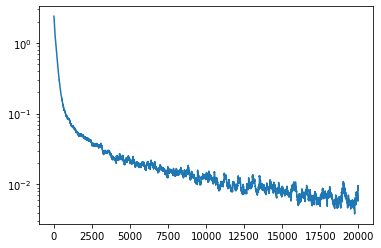

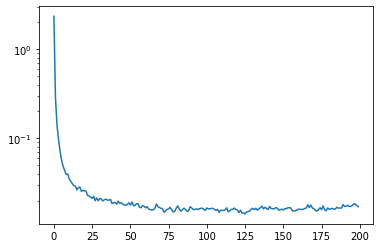

In [46]:
step_size = 0.05
# grad_norm_clip_thr = 1e0 # may be necessary for RNN training; otherwise, set it to an arbitrarily large value or inf  
grad_norm_clip_thr = 1e0
with tf.Session() as sess:   
    Qs_left = [tf.Variable(tf.eye(W.shape.as_list()[0], dtype=dtype), trainable=False) for W in Ws]
    Qs_right = [tf.Variable(tf.eye(W.shape.as_list()[1], dtype=dtype), trainable=False) for W in Ws]
    
    train_loss = train_criterion(Ws)
    grads = tf.gradients(train_loss, Ws)
    
    precond_grads = [psgd.precond_grad_kron(ql, qr, g) for (ql, qr, g) in zip(Qs_left, Qs_right, grads)]
    grad_norm = tf.sqrt(tf.reduce_sum([tf.reduce_sum(g*g) for g in precond_grads]))
    step_size_adjust = tf.minimum(1.0, grad_norm_clip_thr/(grad_norm + 1.2e-38))
    new_Ws = [W - (step_size_adjust*step_size)*g for (W, g) in zip(Ws, precond_grads)]
    update_Ws = [tf.assign(W, new_W) for (W, new_W) in zip(Ws, new_Ws)]
    
    delta_Ws = [tf.random_normal(W.shape, dtype=dtype) for W in Ws]
    grad_deltaw = tf.reduce_sum([tf.reduce_sum(g*v) for (g, v) in zip(grads, delta_Ws)])
    hess_deltaw = tf.gradients(grad_deltaw, Ws)
    
    new_Qs = [psgd.update_precond_kron(ql, qr, dw, dg) for (ql, qr, dw, dg) in zip(Qs_left, Qs_right, delta_Ws, hess_deltaw)]
    update_Qs = [[tf.assign(old_ql, new_q[0]), tf.assign(old_qr, new_q[1])] for (old_ql, old_qr, new_q) in zip(Qs_left, Qs_right, new_Qs)]
    
    test_loss = test_criterion(Ws)     
    
    sess.run(tf.global_variables_initializer())
    avg_train_loss = 0.0
    TrainLoss = list()
    TestLoss = list()
    Time = list()
    for num_iter in range(20000):    
        _train_inputs, _train_outputs = get_batches( )
    
        t0 = time.time()
        _train_loss, _, _ = sess.run([train_loss, update_Ws, update_Qs],
                                     {train_inputs: _train_inputs, train_outputs: _train_outputs})
        Time.append(time.time() - t0)
        nu = min(num_iter/(1.0 + num_iter), 0.99)
        avg_train_loss = nu*avg_train_loss + (1.0 - nu)*_train_loss
        TrainLoss.append(avg_train_loss)      
        if num_iter % 100 == 0:
            _test_loss = sess.run(test_loss)
            TestLoss.append(_test_loss)
            print('train loss: {}; test loss: {}; Time: {}'.format(TrainLoss[-1], TestLoss[-1], np.sum(Time)))

    
plt.figure(1)
plt.semilogy(TrainLoss)
plt.figure(2)
plt.semilogy(TestLoss)

  
scipy.io.savemat('/content/gdrive/My Drive/Colab Notebooks/MS Thesis/Preconditioned SGD/MNIST/results/kron_precond.mat', {'TrainLoss': TrainLoss, 'TestLoss': TestLoss, 'Time': Time})

# PSGD with Kronecker Product Preconditioning (Approximated H*v product)

train loss: 2.3763318061828613; test loss: 2.3309996128082275, time:0.47595930099487305
train loss: 1.1684322467982766; test loss: 0.324663907289505, time:1.769965410232544
train loss: 0.6811336567567128; test loss: 0.15775328874588013, time:3.049191474914551
train loss: 0.4021287989644428; test loss: 0.1107654944062233, time:4.345352411270142
train loss: 0.26676020988093224; test loss: 0.08112511038780212, time:5.640723943710327
train loss: 0.18586098073506319; test loss: 0.06502600759267807, time:6.919572591781616
train loss: 0.14361391421837616; test loss: 0.056564416736364365, time:8.18658995628357
train loss: 0.12127435421487182; test loss: 0.04927028715610504, time:9.462463855743408
train loss: 0.10825606564619131; test loss: 0.04373965784907341, time:10.743369579315186
train loss: 0.0924864355479647; test loss: 0.03855213522911072, time:12.031888961791992
train loss: 0.08490365857153159; test loss: 0.036930352449417114, time:13.313703775405884
train loss: 0.0806740773697389; tes

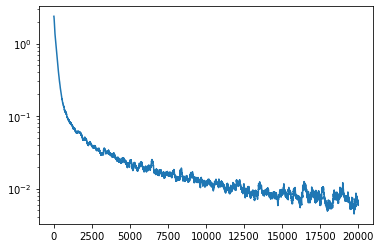

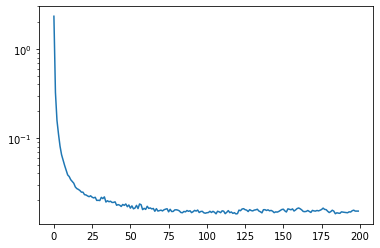

In [47]:
step_size = 0.05
grad_norm_clip_thr = 1e0   # gradients clipping may be necessary for RNN training; 
                            # set it to an extremely large value if no clipping is required   

with tf.Session() as sess:   
    eps = max([np.finfo(W.dtype.as_numpy_dtype).eps for W in Ws])
    
    Qs_left = [tf.Variable(tf.eye(W.shape.as_list()[0], dtype=dtype), trainable=False) for W in Ws]
    Qs_right = [tf.Variable(tf.eye(W.shape.as_list()[1], dtype=dtype), trainable=False) for W in Ws]
    
    train_loss = train_criterion(Ws)
    grads = tf.gradients(train_loss, Ws)
    
    precond_grads = [psgd.precond_grad_kron(ql, qr, g) for (ql, qr, g) in zip(Qs_left, Qs_right, grads)]
    grad_norm = tf.sqrt(tf.reduce_sum([tf.reduce_sum(g*g) for g in precond_grads]))
    step_size_adjust = tf.minimum(1.0, grad_norm_clip_thr/(grad_norm + 1.2e-38))
    new_Ws = [W - (step_size_adjust*step_size)*g for (W, g) in zip(Ws, precond_grads)]
    update_Ws = [tf.assign(W, new_W) for (W, new_W) in zip(Ws, new_Ws)]
    
    delta_Ws = [tf.random_normal(W.shape, mean=0.0, stddev=tf.sqrt(eps), dtype=dtype) for W in Ws]
    perturbed_Ws = [W + d for (W, d) in zip(Ws, delta_Ws)]
    perturbed_grads = tf.gradients(train_criterion(perturbed_Ws), Ws)
    delta_grads = [g1 - g0 for (g1, g0) in zip(perturbed_grads, grads)]
    
    new_Qs = [psgd.update_precond_kron(ql, qr, dw, dg) for (ql, qr, dw, dg) in zip(Qs_left, Qs_right, delta_Ws, delta_grads)]
    update_Qs = [[tf.assign(old_ql, new_q[0]), tf.assign(old_qr, new_q[1])] for (old_ql, old_qr, new_q) in zip(Qs_left, Qs_right, new_Qs)]
    
    test_loss = test_criterion(Ws)     
    
    sess.run(tf.global_variables_initializer())
    avg_train_loss = 0.0
    TrainLoss = list()
    TestLoss = list()
    Time = list()
    for num_iter in range(20000):    
        _train_inputs, _train_outputs = get_batches( )
    
        t0 = time.time()
        _train_loss, _, _ = sess.run([train_loss, update_Ws, update_Qs],
                                     {train_inputs: _train_inputs, train_outputs: _train_outputs})
        Time.append(time.time() - t0)
        nu = min(num_iter/(1.0 + num_iter), 0.99)
        avg_train_loss = nu*avg_train_loss + (1.0 - nu)*_train_loss
        TrainLoss.append(avg_train_loss)      
        if num_iter % 100 == 0:
            _test_loss = sess.run(test_loss)
            TestLoss.append(_test_loss)
            print('train loss: {}; test loss: {}, time:{}'.format(TrainLoss[-1], TestLoss[-1], np.sum(Time)))


plt.figure(1)
plt.semilogy(TrainLoss)
plt.figure(2)
plt.semilogy(TestLoss)

  
scipy.io.savemat('/content/gdrive/My Drive/Colab Notebooks/MS Thesis/Preconditioned SGD/MNIST/results/kron_precond_approx.mat', {'TrainLoss': TrainLoss, 'TestLoss': TestLoss, 'Time':Time})

# PSGD with SPLU

train loss: 2.455831527709961; test loss: 2.3261451721191406; Time: 0.7071282863616943
train loss: 1.5486351391136655; test loss: 0.7052022218704224; Time: 1.9941682815551758
train loss: 1.1216344712681436; test loss: 0.40314874053001404; Time: 3.2845993041992188
train loss: 0.8117638698408417; test loss: 0.2848333418369293; Time: 4.5684874057769775
train loss: 0.573190893979561; test loss: 0.19259746372699738; Time: 5.858216762542725
train loss: 0.4054223535610768; test loss: 0.15130271017551422; Time: 7.1474528312683105
train loss: 0.3083379122542445; test loss: 0.12609784305095673; Time: 8.433934926986694
train loss: 0.2525079104131178; test loss: 0.10885417461395264; Time: 9.718921899795532
train loss: 0.21330945149117417; test loss: 0.0941382572054863; Time: 11.000239133834839
train loss: 0.18738318984110147; test loss: 0.0936916247010231; Time: 12.28158712387085
train loss: 0.17730235247676168; test loss: 0.08755870163440704; Time: 13.565049886703491
train loss: 0.157257809096808

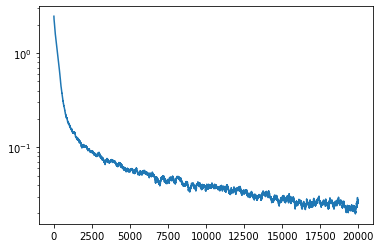

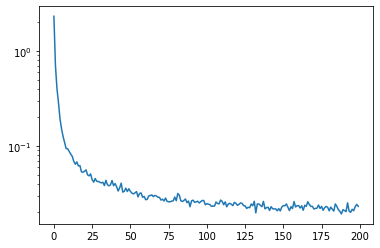

In [48]:
r = 10 # order of sparse LU preconditioner
step_size = 0.05
grad_norm_clip_thr = 1e0    # if diverges, try gradient clipping  
         
with tf.Session() as sess:
    num_para = sum([np.prod(W.shape.as_list()) for W in Ws])
    # lower triangular matrix is [L1, 0; L2, diag(l3)]; L12 is [L1; L2]
    L12 = tf.Variable(tf.concat([tf.eye(r, dtype=dtype),
                                 tf.zeros([num_para - r, r], dtype=dtype)], axis=0), trainable=False)
    l3 = tf.Variable(tf.ones([num_para - r, 1], dtype=dtype), trainable=False)
    # upper triangular matrix is [U1, U2; 0, diag(u3)]; U12 is [U1, U2]
    U12 = tf.Variable(tf.concat([tf.eye(r, dtype=dtype),
                                 tf.zeros([r, num_para - r], dtype=dtype)], axis=1), trainable=False)
    u3 = tf.Variable(tf.ones([num_para - r, 1], dtype=dtype), trainable=False)
        
    train_loss = train_criterion(Ws)
    grads = tf.gradients(train_loss, Ws)
    
    precond_grads = psgd.precond_grad_splu(L12, l3, U12, u3, grads)
    grad_norm = tf.sqrt(tf.reduce_sum([tf.reduce_sum(g*g) for g in precond_grads]))
    step_size_adjust = tf.minimum(1.0, grad_norm_clip_thr/(grad_norm + 1.2e-38))
    new_Ws = [W - (step_size_adjust*step_size)*g for (W, g) in zip(Ws, precond_grads)]
    update_Ws = [tf.assign(W, new_W) for (W, new_W) in zip(Ws, new_Ws)]
    
    delta_Ws = [tf.random_normal(W.shape, dtype=dtype) for W in Ws]
    grad_deltaw = tf.reduce_sum([tf.reduce_sum(g*v) for (g, v) in zip(grads, delta_Ws)]) # dot(grads, delta_Ws)
    hess_deltaw = tf.gradients(grad_deltaw, Ws) # Hessian * delta_Ws
    
    new_L12, new_l3, new_U12, new_u3 = psgd.update_precond_splu(L12, l3, U12, u3, delta_Ws, hess_deltaw)
    update_Q = [tf.assign(L12, new_L12), tf.assign(l3, new_l3),
                tf.assign(U12, new_U12), tf.assign(u3, new_u3)]
    
    test_loss = test_criterion(Ws)  
    
    sess.run(tf.global_variables_initializer())
    avg_train_loss = 0.0
    TrainLoss = list()
    TestLoss = list()
    Time = list()
    for num_iter in range(20000):    
        _train_inputs, _train_outputs = get_batches()
    
        t0 = time.time()
        _train_loss, _,_ = sess.run([train_loss, update_Ws, update_Q],
                                    {train_inputs: _train_inputs, train_outputs: _train_outputs})
        Time.append(time.time() - t0)
        nu = min(num_iter/(1.0 + num_iter), 0.99)
        avg_train_loss = nu*avg_train_loss + (1.0 - nu)*_train_loss
        TrainLoss.append(avg_train_loss)      
        if num_iter % 100 == 0:
            _test_loss = sess.run(test_loss)
            TestLoss.append(_test_loss)
            print('train loss: {}; test loss: {}; Time: {}'.format(TrainLoss[-1], TestLoss[-1],np.sum(Time)))

    
plt.figure(1)
plt.semilogy(TrainLoss)
plt.figure(2)
plt.semilogy(TestLoss)

  
scipy.io.savemat('/content/gdrive/My Drive/Colab Notebooks/MS Thesis/Preconditioned SGD/MNIST/results/splu_precond.mat', {'TrainLoss': TrainLoss, 'TestLoss': TestLoss, 'Time':Time})

# PSGD with SCAN preconditioning

train loss: 2.358865261077881; test loss: 2.328836679458618; Time:0.8746957778930664
train loss: 1.4849509680747988; test loss: 0.6454827189445496; Time:2.234793186187744
train loss: 1.1154725045984315; test loss: 0.4957406222820282; Time:3.58821439743042
train loss: 0.926145613003852; test loss: 0.45502716302871704; Time:4.934019088745117
train loss: 0.8282710307690909; test loss: 0.41718682646751404; Time:6.27764630317688
train loss: 0.763502083794429; test loss: 0.3862207233905792; Time:7.639147043228149
train loss: 0.7058139114523478; test loss: 0.35392236709594727; Time:9.003875017166138
train loss: 0.656000181246786; test loss: 0.32643043994903564; Time:10.371211767196655
train loss: 0.6071861828986638; test loss: 0.3008822798728943; Time:11.715867042541504
train loss: 0.558681921523706; test loss: 0.27782681584358215; Time:13.057724952697754
train loss: 0.5136213128199094; test loss: 0.25806212425231934; Time:14.395719766616821
train loss: 0.4839984098790615; test loss: 0.242547

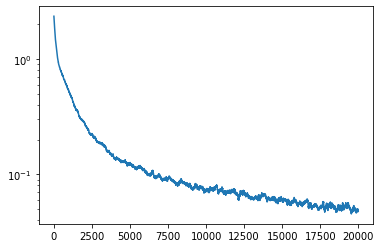

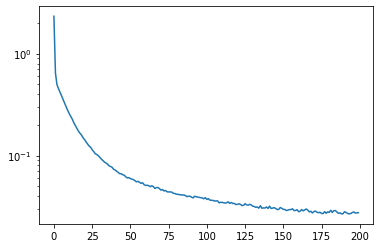

In [49]:
step_size = 0.05
grad_norm_clip_thr = 1e0 # may be necessary for RNN training; otherwise, set it to an arbitrarily large value or inf  

with tf.Session() as sess:   
    # first rows define the diagonal part; must be positive numbers
    qs_left = [tf.Variable(tf.concat([tf.ones((1, W.shape.as_list()[0])),
                                      tf.zeros((1, W.shape.as_list()[0]))], axis=0), trainable=False) for W in Ws]
    qs_right = [tf.Variable(tf.ones((1, W.shape.as_list()[1])), trainable=False) for W in Ws]
    
    train_loss = train_criterion(Ws)
    grads = tf.gradients(train_loss, Ws)
    
    precond_grads = [psgd.precond_grad_scan(ql, qr, g) for (ql, qr, g) in zip(qs_left, qs_right, grads)]
    grad_norm = tf.sqrt(tf.reduce_sum([tf.reduce_sum(g*g) for g in precond_grads]))
    step_size_adjust = tf.minimum(1.0, grad_norm_clip_thr/(grad_norm + 1.2e-38))
    new_Ws = [W - (step_size_adjust*step_size)*g for (W, g) in zip(Ws, precond_grads)]
    update_Ws = [tf.assign(W, new_W) for (W, new_W) in zip(Ws, new_Ws)]
    
    delta_Ws = [tf.random_normal(W.shape, dtype=dtype) for W in Ws]
    grad_deltaw = tf.reduce_sum([tf.reduce_sum(g*v) for (g, v) in zip(grads, delta_Ws)])
    hess_deltaw = tf.gradients(grad_deltaw, Ws)
    
    new_qs = [psgd.update_precond_scan(ql, qr, dw, dg) for (ql, qr, dw, dg) in zip(qs_left, qs_right, delta_Ws, hess_deltaw)]
    update_qs = [[tf.assign(old_ql, new_q[0]), tf.assign(old_qr, new_q[1])] for (old_ql, old_qr, new_q) in zip(qs_left, qs_right, new_qs)]
    
    test_loss = test_criterion(Ws)     
    
    sess.run(tf.global_variables_initializer())
    avg_train_loss = 0.0
    TrainLoss = list()
    TestLoss = list()
    Time = list()
    for num_iter in range(20000):    
        _train_inputs, _train_outputs = get_batches( )
    
        t0 = time.time()
        _train_loss, _, _ = sess.run([train_loss, update_Ws, update_qs],
                                     {train_inputs: _train_inputs, train_outputs: _train_outputs})
        Time.append(time.time() - t0)
        nu = min(num_iter/(1.0 + num_iter), 0.99)
        avg_train_loss = nu*avg_train_loss + (1.0 - nu)*_train_loss
        TrainLoss.append(avg_train_loss)      
        if num_iter % 100 == 0:
            _test_loss = sess.run(test_loss)
            TestLoss.append(_test_loss)
            print('train loss: {}; test loss: {}; Time:{}'.format(TrainLoss[-1], TestLoss[-1], np.sum(Time)))

    
plt.figure(1)
plt.semilogy(TrainLoss)
plt.figure(2)
plt.semilogy(TestLoss)

  
scipy.io.savemat('/content/gdrive/My Drive/Colab Notebooks/MS Thesis/Preconditioned SGD/MNIST/results/scan_precond.mat', {'TrainLoss': TrainLoss, 'TestLoss': TestLoss, 'Time':Time})

# PSGD with SCAN preconditioning (Approximated Hv Product)

train loss: 2.3566970825195312; test loss: 2.325457811355591; Time: 0.7736549377441406
train loss: 1.5080116786539564; test loss: 0.7106464505195618; Time: 1.9458024501800537
train loss: 1.1449736567853992; test loss: 0.5208243131637573; Time: 3.095447301864624
train loss: 0.9518818405694619; test loss: 0.4736519455909729; Time: 4.264572381973267
train loss: 0.867939706855957; test loss: 0.4402835965156555; Time: 5.45554780960083
train loss: 0.8014490196153493; test loss: 0.41299471259117126; Time: 6.641736030578613
train loss: 0.7491394784339219; test loss: 0.378739595413208; Time: 7.838418960571289
train loss: 0.6963862214283433; test loss: 0.3494465947151184; Time: 8.962984800338745
train loss: 0.6378468932071801; test loss: 0.32530638575553894; Time: 10.165223121643066
train loss: 0.5836388619502973; test loss: 0.2942437529563904; Time: 11.338940382003784
train loss: 0.544092779660176; test loss: 0.2717280387878418; Time: 12.493785858154297
train loss: 0.509922582309093; test loss:

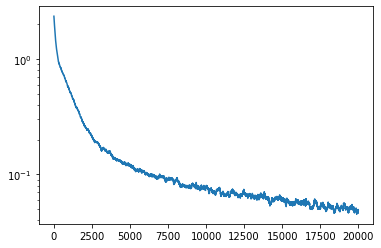

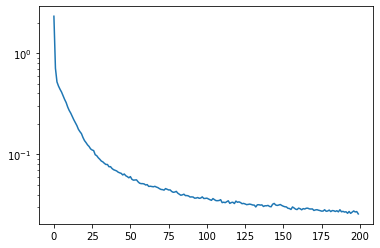

In [50]:
step_size = 0.05
grad_norm_clip_thr = 1e0   # gradients clipping may be necessary for RNN training; 
                            # set it to an extremely large value if no clipping is required   

with tf.Session() as sess:   
    eps = max([np.finfo(W.dtype.as_numpy_dtype).eps for W in Ws])
    # first rows define the diagonal part; must be positive numbers 
    qs_left = [tf.Variable(tf.concat([tf.ones((1, W.shape.as_list()[0])),
                                      tf.zeros((1, W.shape.as_list()[0]))], axis=0), trainable=False) for W in Ws]
    qs_right = [tf.Variable(tf.ones((1, W.shape.as_list()[1])), trainable=False) for W in Ws]
    
    train_loss = train_criterion(Ws)
    grads = tf.gradients(train_loss, Ws)
    
    precond_grads = [psgd.precond_grad_scan(ql, qr, g) for (ql, qr, g) in zip(qs_left, qs_right, grads)]
    grad_norm = tf.sqrt(tf.reduce_sum([tf.reduce_sum(g*g) for g in precond_grads]))
    step_size_adjust = tf.minimum(1.0, grad_norm_clip_thr/(grad_norm + 1.2e-38))
    new_Ws = [W - (step_size_adjust*step_size)*g for (W, g) in zip(Ws, precond_grads)]
    update_Ws = [tf.assign(W, new_W) for (W, new_W) in zip(Ws, new_Ws)]
    
    delta_Ws = [tf.random_normal(W.shape, mean=0.0, stddev=tf.sqrt(eps), dtype=dtype) for W in Ws]
    perturbed_Ws = [W + d for (W, d) in zip(Ws, delta_Ws)]
    perturbed_grads = tf.gradients(train_criterion(perturbed_Ws), Ws)
    delta_grads = [g1 - g0 for (g1, g0) in zip(perturbed_grads, grads)]
    
    new_qs = [psgd.update_precond_scan(ql, qr, dw, dg) for (ql, qr, dw, dg) in zip(qs_left, qs_right, delta_Ws, delta_grads)]
    update_qs = [[tf.assign(old_ql, new_q[0]), tf.assign(old_qr, new_q[1])] for (old_ql, old_qr, new_q) in zip(qs_left, qs_right, new_qs)]
    
    test_loss = test_criterion(Ws)     
    
    sess.run(tf.global_variables_initializer())
    avg_train_loss = 0.0
    TrainLoss = list()
    TestLoss = list()
    Time = list()
    for num_iter in range(20000):    
        _train_inputs, _train_outputs = get_batches( )
    
        t0 = time.time()
        _train_loss, _, _ = sess.run([train_loss, update_Ws, update_qs],
                                     {train_inputs: _train_inputs, train_outputs: _train_outputs})
        Time.append(time.time() - t0)
        nu = min(num_iter/(1.0 + num_iter), 0.99)
        avg_train_loss = nu*avg_train_loss + (1.0 - nu)*_train_loss
        TrainLoss.append(avg_train_loss)      
        if num_iter % 100 == 0:
            _test_loss = sess.run(test_loss)
            TestLoss.append(_test_loss)
            print('train loss: {}; test loss: {}; Time: {}'.format(TrainLoss[-1], TestLoss[-1], np.sum(Time)))


plt.figure(1)
plt.semilogy(TrainLoss)
plt.figure(2)
plt.semilogy(TestLoss)

  
scipy.io.savemat('/content/gdrive/My Drive/Colab Notebooks/MS Thesis/Preconditioned SGD/MNIST/results/scan_precond_approx.mat', {'TrainLoss': TrainLoss, 'TestLoss': TestLoss, 'Time':Time})

# Kronecker Product + ADAM

train loss: 2.4484381675720215; test loss: 2.35062575340271, time:0.683307409286499
train loss: 1.3865793360114103; test loss: 0.30967602133750916, time:2.0710582733154297
train loss: 0.7019445943099977; test loss: 0.1100681871175766, time:3.46207857131958
train loss: 0.3594029372690218; test loss: 0.06474438309669495, time:4.825123071670532
train loss: 0.20292391761947332; test loss: 0.04421895742416382, time:6.194580078125
train loss: 0.12852820502132062; test loss: 0.03725339099764824, time:7.578229188919067
train loss: 0.092290157706446; test loss: 0.03448747470974922, time:9.005983591079712
train loss: 0.07298498656746835; test loss: 0.030149346217513084, time:10.399168729782104
train loss: 0.06466691004366655; test loss: 0.027979714795947075, time:11.795826196670532
train loss: 0.054141574890353344; test loss: 0.027779633179306984, time:13.171737909317017
train loss: 0.04924907872953463; test loss: 0.02595418319106102, time:14.551153182983398
train loss: 0.045050149230759694; tes

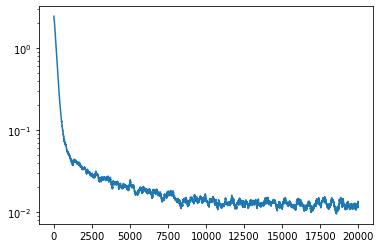

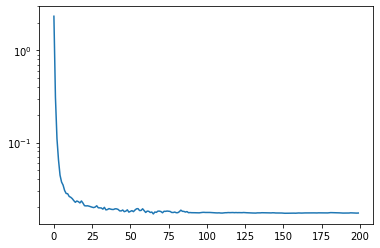

In [51]:
step_size = 0.05
grad_norm_clip_thr = 1e0   # gradients clipping may be necessary for RNN training; 
                            # set it to an extremely large value if no clipping is required   
beta1 = 0.9
beta2 = 0.999
offset = 1e-9

with tf.Session() as sess:   
    eps = max([np.finfo(W.dtype.as_numpy_dtype).eps for W in Ws])
    
    grads_vars = [tf.Variable(tf.zeros(W.shape, dtype=dtype), trainable=False) for W in Ws]
    grads_moment = [tf.Variable(tf.zeros(W.shape, dtype=dtype), trainable=False) for W in Ws]

    Qs_left = [tf.Variable(tf.eye(W.shape.as_list()[0], dtype=dtype), trainable=False) for W in Ws]
    Qs_right = [tf.Variable(tf.eye(W.shape.as_list()[1], dtype=dtype), trainable=False) for W in Ws]
    
    train_loss = train_criterion(Ws)
    grads = tf.gradients(train_loss, Ws)

    new_grads_moment = [beta1*old + (1.0 - beta1)*new for (old, new) in zip(grads_moment, grads)]
    new_grads_vars = [beta2*old + (1.0 - beta2)*new*new for (old, new) in zip(grads_vars, grads)]
    new_grads_moment_hat = [m/(1-beta1**adam_step) for m in new_grads_moment]
    new_grads_vars_hat = [v/(1-beta2**adam_step) for v in new_grads_vars]

    adam_grads = [m/tf.sqrt(v + offset) for (m,v) in zip(new_grads_moment_hat,new_grads_vars_hat)]

    precond_grads = [psgd.precond_grad_kron(ql, qr, g) for (ql, qr, g) in zip(Qs_left, Qs_right, adam_grads)]
    grad_norm = tf.sqrt(tf.reduce_sum([tf.reduce_sum(g*g) for g in precond_grads]))
    step_size_adjust = tf.minimum(1.0, grad_norm_clip_thr/(grad_norm + 1.2e-38))
    
    new_Ws = [W - (step_size_adjust*step_size)*pG for (W, pG) in zip(Ws,precond_grads)]
    update_Ws = [tf.assign(W, new_W) for (W, new_W) in zip(Ws, new_Ws)]
    
    update_grads_vars = [tf.assign(old, new) for (old, new) in zip(grads_vars, new_grads_vars)]
    update_grads_moment = [tf.assign(old, new) for (old, new) in zip(grads_moment, new_grads_moment)]
    
    delta_Ws = [tf.random_normal(W.shape, mean=0.0, stddev=tf.sqrt(eps), dtype=dtype) for W in Ws]
    perturbed_Ws = [W + d for (W, d) in zip(Ws, delta_Ws)]
    perturbed_grads = tf.gradients(train_criterion(perturbed_Ws), Ws)
    delta_grads = [g1 - g0 for (g1, g0) in zip(perturbed_grads, grads)]
    
    new_Qs = [psgd.update_precond_kron(ql, qr, dw, dg) for (ql, qr, dw, dg) in zip(Qs_left, Qs_right, delta_Ws, delta_grads)]
    update_Qs = [[tf.assign(old_ql, new_q[0]), tf.assign(old_qr, new_q[1])] for (old_ql, old_qr, new_q) in zip(Qs_left, Qs_right, new_Qs)]
    
    test_loss = test_criterion(Ws)     
    
    sess.run(tf.global_variables_initializer())
    avg_train_loss = 0.0
    TrainLoss = list()
    TestLoss = list()
    Time = list()
    t = 0
    for num_iter in range(20000):    
        _train_inputs, _train_outputs = get_batches( )
        t = t + 1
        t0 = time.time()
        _train_loss, _, _,_,_ = sess.run([train_loss, update_Ws, update_grads_moment, update_grads_vars, update_Qs],
                                     {train_inputs: _train_inputs, train_outputs: _train_outputs, adam_step: t})
        Time.append(time.time() - t0)
        nu = min(num_iter/(1.0 + num_iter), 0.99)
        avg_train_loss = nu*avg_train_loss + (1.0 - nu)*_train_loss
        TrainLoss.append(avg_train_loss)      
        if num_iter % 100 == 0:
            _test_loss = sess.run(test_loss)
            TestLoss.append(_test_loss)
            print('train loss: {}; test loss: {}, time:{}'.format(TrainLoss[-1], TestLoss[-1], np.sum(Time)))


plt.figure(1)
plt.semilogy(TrainLoss)
plt.figure(2)
plt.semilogy(TestLoss)

  
scipy.io.savemat('/content/gdrive/My Drive/Colab Notebooks/MS Thesis/Preconditioned SGD/MNIST/results/kron_precond_adam.mat', {'TrainLoss': TrainLoss, 'TestLoss': TestLoss, 'Time':Time})

# Comparison of All above second order approximations

In [0]:
sgd = scipy.io.loadmat('/content/gdrive/My Drive/Colab Notebooks/MS Thesis/Preconditioned SGD/MNIST/results/SGD.mat')
adam = scipy.io.loadmat('/content/gdrive/My Drive/Colab Notebooks/MS Thesis/Preconditioned SGD/MNIST/results/adam.mat')
adam_kron = scipy.io.loadmat('/content/gdrive/My Drive/Colab Notebooks/MS Thesis/Preconditioned SGD/MNIST/results/kron_precond_adam.mat')
rmsprop = scipy.io.loadmat('/content/gdrive/My Drive/Colab Notebooks/MS Thesis/Preconditioned SGD/MNIST/results/rmsprop.mat')
esgd = scipy.io.loadmat('/content/gdrive/My Drive/Colab Notebooks/MS Thesis/Preconditioned SGD/MNIST/results/ESGD.mat')
kron_precond = scipy.io.loadmat('/content/gdrive/My Drive/Colab Notebooks/MS Thesis/Preconditioned SGD/MNIST/results/kron_precond.mat')
kron_precond_approx = scipy.io.loadmat('/content/gdrive/My Drive/Colab Notebooks/MS Thesis/Preconditioned SGD/MNIST/results/kron_precond_approx.mat')
splu = scipy.io.loadmat('/content/gdrive/My Drive/Colab Notebooks/MS Thesis/Preconditioned SGD/MNIST/results/splu_precond.mat')
scan_precond = scipy.io.loadmat('/content/gdrive/My Drive/Colab Notebooks/MS Thesis/Preconditioned SGD/MNIST/results/scan_precond.mat')
scan_precond_approx = scipy.io.loadmat('/content/gdrive/My Drive/Colab Notebooks/MS Thesis/Preconditioned SGD/MNIST/results/scan_precond_approx.mat')

In [0]:
sgd_time = sgd.get('Time').reshape(20000,)
adam_time = adam.get('Time').reshape(20000,)
rmsprop_time = rmsprop.get('Time').reshape(40000,)
esgd_time = esgd.get('Time').reshape(20000,)
kron_time =  kron_precond.get('Time').reshape(20000,)
kron_approx_time = kron_precond_approx.get('Time').reshape(20000,)
splu_time = splu.get('Time').reshape(20000,)
scan_time = scan_precond.get('Time').reshape(20000,)
scan_approx_time = scan_precond_approx.get('Time').reshape(20000,)
adam_kron_time = adam_kron.get('Time').reshape(20000,)


In [0]:
sgd_TrainLoss = sgd.get('TrainLoss').reshape(20000,)
adam_TrainLoss = adam.get('TrainLoss').reshape(20000,)
rmsprop_TrainLoss = rmsprop.get('TrainLoss').reshape(40000,)
esgd_TrainLoss = esgd.get('TrainLoss').reshape(20000,)
kron_TrainLoss =  kron_precond.get('TrainLoss').reshape(20000,)
kron_approx_TrainLoss = kron_precond_approx.get('TrainLoss').reshape(20000,)
splu_TrainLoss = splu.get('TrainLoss').reshape(20000,)
scan_TrainLoss = scan_precond.get('TrainLoss').reshape(20000,)
scan_approx_TrainLoss = scan_precond_approx.get('TrainLoss').reshape(20000,)
adam_kron_TrainLoss = adam_kron.get('TrainLoss').reshape(20000,)

In [0]:
sgd_TestLoss = sgd.get('TestLoss').reshape(200,)
adam_TestLoss = adam.get('TestLoss').reshape(200,)
rmsprop_TestLoss = rmsprop.get('TestLoss').reshape(400,)
esgd_TestLoss = esgd.get('TestLoss').reshape(200,)
kron_TestLoss =  kron_precond.get('TestLoss').reshape(200,)
kron_approx_TestLoss = kron_precond_approx.get('TestLoss').reshape(200,)
splu_TestLoss = splu.get('TestLoss').reshape(200,)
scan_TestLoss = scan_precond.get('TestLoss').reshape(200,)
scan_approx_TestLoss = scan_precond_approx.get('TestLoss').reshape(200,)
adam_kron_TestLoss = adam_kron.get('TestLoss').reshape(200,)


In [66]:
optimizers = ['SGD','adam', 'RMSprop', 'ESGD', 'kron', 'kron_approx', 'SPLU', 'SCAN', 'SCAN_approx','hybrid_ADAMKRON']
training_time = [np.sum(sgd_time),np.sum(adam_time), np.sum(rmsprop_time), np.sum(esgd_time), np.sum(kron_time),
                 np.sum(kron_approx_time),np.sum(splu_time), np.sum(scan_time), np.sum(scan_approx_time),np.sum(adam_kron_time)]
print(tabulate(zip(optimizers, training_time),headers = ['optimizers','time (sec)']))

optimizers         time (sec)
---------------  ------------
SGD                   107.508
adam                  123.081
RMSprop               227.838
ESGD                  241.739
kron                  302.371
kron_approx           256.894
SPLU                  258.228
SCAN                  271.47
SCAN_approx           232.39
hybrid_ADAMKRON       274.346


/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


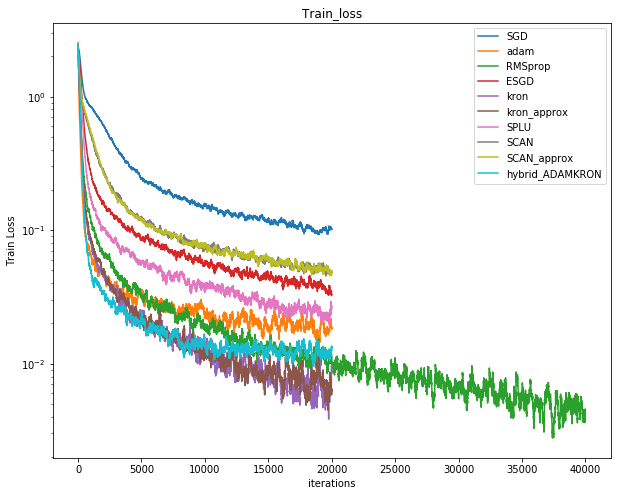

In [67]:
fig = plt.figure(figsize=(10,8))

plt.semilogy(sgd_TrainLoss)
plt.semilogy(adam_TrainLoss)
plt.semilogy(rmsprop_TrainLoss)
plt.semilogy(esgd_TrainLoss)
plt.semilogy(kron_TrainLoss)
plt.semilogy(kron_approx_TrainLoss)
plt.semilogy(splu_TrainLoss)
plt.semilogy(scan_TrainLoss)
plt.semilogy(scan_approx_TrainLoss)
plt.semilogy(adam_kron_TrainLoss)

plt.title('Train_loss')
plt.xlabel('iterations')
plt.ylabel('Train Loss')
plt.legend(optimizers)

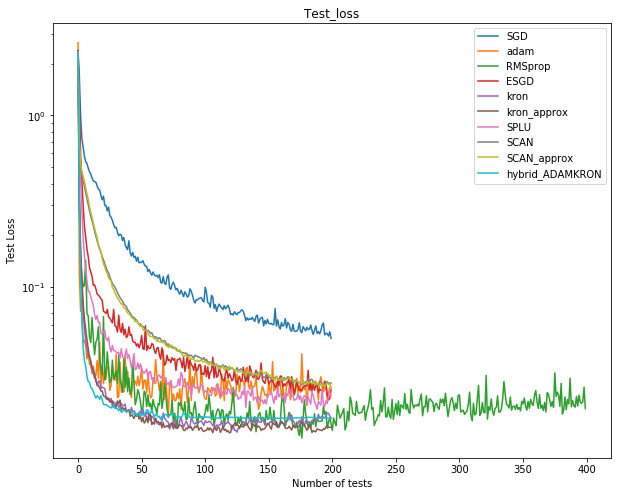

In [68]:
fig = plt.figure(figsize=(10,8))

plt.semilogy(sgd_TestLoss)
plt.semilogy(adam_TestLoss)
plt.semilogy(rmsprop_TestLoss)
plt.semilogy(esgd_TestLoss)
plt.semilogy(kron_TestLoss)
plt.semilogy(kron_approx_TestLoss)
plt.semilogy(splu_TestLoss)
plt.semilogy(scan_TestLoss)
plt.semilogy(scan_approx_TestLoss)
plt.semilogy(adam_kron_TestLoss)

plt.title('Test_loss')
plt.xlabel('Number of tests')
plt.ylabel('Test Loss')
plt.legend(optimizers)


In [0]:
sgd_t = np.cumsum(sgd_time)
adam_t =  np.cumsum(adam_time)
rmsprop_t = np.cumsum(rmsprop_time)
esgd_t = np.cumsum(esgd_time)
kron_t =  np.cumsum(kron_time)
kron_approx_t = np.cumsum(kron_approx_time)
splu_t = np.cumsum(splu_time)
scan_t = np.cumsum(scan_time)
scan_approx_t =np.cumsum(scan_approx_time)
adam_kron_t =  np.cumsum(adam_kron_time)


sgd_tt = []
adam_tt =  []
rmsprop_tt = [] 
esgd_tt = []
kron_tt = []
kron_approx_tt =[] 
splu_tt = []
scan_tt = []
scan_approx_tt = []
adam_kron_tt = []

for i in range(0,20000,100):
  sgd_tt.append(sgd_t[i])
  adam_tt.append(adam_t[i])
  
  esgd_tt.append(esgd_t[i])
  kron_tt.append(kron_t[i])
  kron_approx_tt.append(kron_approx_t[i])
  splu_tt.append(splu_t[i])
  scan_tt.append(scan_t[i])
  scan_approx_tt.append(scan_approx_t[i])
  adam_kron_tt.append(adam_kron_t[i])

for i in range(0,40000,100):
  rmsprop_tt.append(rmsprop_t[i])

/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


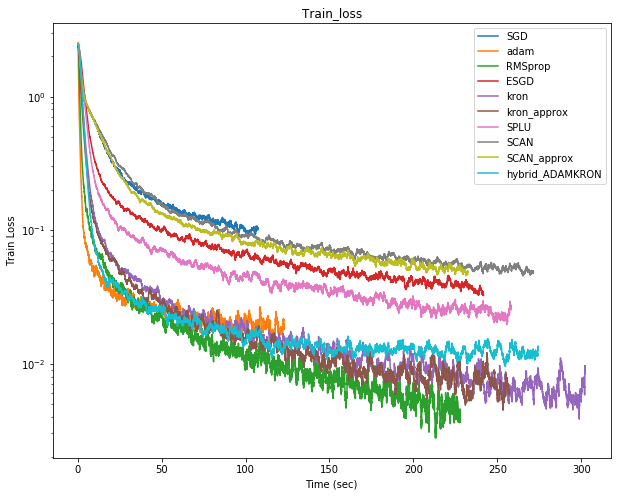

In [86]:
fig = plt.figure(figsize=(10,8))

plt.semilogy(sgd_t,sgd_TrainLoss)
plt.semilogy(adam_t,adam_TrainLoss)
plt.semilogy(rmsprop_t,rmsprop_TrainLoss)
plt.semilogy(esgd_t,esgd_TrainLoss)
plt.semilogy(kron_t, kron_TrainLoss)
plt.semilogy(kron_approx_t, kron_approx_TrainLoss)
plt.semilogy(splu_t, splu_TrainLoss)
plt.semilogy(scan_t, scan_TrainLoss)
plt.semilogy(scan_approx_t, scan_approx_TrainLoss)
plt.semilogy(adam_kron_t,adam_kron_TrainLoss)

plt.title('Train_loss')
plt.xlabel('Time (sec)')
plt.ylabel('Train Loss')
plt.legend(optimizers)
# plt.ylim([0,0.5])

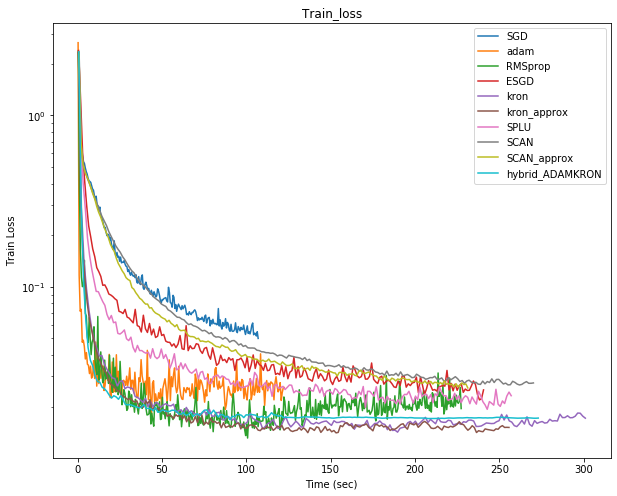

In [87]:
fig = plt.figure(figsize=(10,8))

plt.semilogy(sgd_tt,sgd_TestLoss)
plt.semilogy(adam_tt,adam_TestLoss)
plt.semilogy(rmsprop_tt,rmsprop_TestLoss)
plt.semilogy(esgd_tt,esgd_TestLoss)
plt.semilogy(kron_tt, kron_TestLoss)
plt.semilogy(kron_approx_tt, kron_approx_TestLoss)
plt.semilogy(splu_tt, splu_TestLoss)
plt.semilogy(scan_tt, scan_TestLoss)
plt.semilogy(scan_approx_tt, scan_approx_TestLoss)
plt.semilogy(adam_kron_tt,adam_kron_TestLoss)

plt.title('Train_loss')
plt.xlabel('Time (sec)')
plt.ylabel('Train Loss')
plt.legend(optimizers)